<a href="https://colab.research.google.com/github/sruthisharma88/Feature-engineering/blob/main/Copy_of_Insurance_Claims_Fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("shivamb/vehicle-claim-fraud-detection")

print("Path to dataset files:", path)

100%|██████████| 348k/348k [00:00<00:00, 714kB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/shivamb/vehicle-claim-fraud-detection/versions/1


In [ ]:
import warnings
warnings.filterwarnings('ignore')

# Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
fraud_df = pd.read_csv(path + '/fraud_oracle.csv')
print("Dimension of data frame:", fraud_df.shape)
fraud_df.head()

Dimension of data frame: (15420, 33)


,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,...,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,Year,BasePolicy
0,Dec,5,Wednesday,Honda,Urban,Tuesday,Jan,1,Female,Single,...,3 years,26 to 30,No,No,External,none,1 year,3 to 4,1994,Liability
1,Jan,3,Wednesday,Honda,Urban,Monday,Jan,4,Male,Single,...,6 years,31 to 35,Yes,No,External,none,no change,1 vehicle,1994,Collision
2,Oct,5,Friday,Honda,Urban,Thursday,Nov,2,Male,Married,...,7 years,41 to 50,No,No,External,none,no change,1 vehicle,1994,Collision
3,Jun,2,Saturday,Toyota,Rural,Friday,Jul,1,Male,Married,...,more than 7,51 to 65,Yes,No,External,more than 5,no change,1 vehicle,1994,Liability
4,Jan,5,Monday,Honda,Urban,Tuesday,Feb,2,Female,Single,...,5 years,31 to 35,No,No,External,none,no change,1 vehicle,1994,Collision


In [ ]:
fraud_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15420 entries, 0 to 15419
Data columns (total 33 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Month                 15420 non-null  object
 1   WeekOfMonth           15420 non-null  int64 
 2   DayOfWeek             15420 non-null  object
 3   Make                  15420 non-null  object
 4   AccidentArea          15420 non-null  object
 5   DayOfWeekClaimed      15420 non-null  object
 6   MonthClaimed          15420 non-null  object
 7   WeekOfMonthClaimed    15420 non-null  int64 
 8   Sex                   15420 non-null  object
 9   MaritalStatus         15420 non-null  object
 10  Age                   15420 non-null  int64 
 11  Fault                 15420 non-null  object
 12  PolicyType            15420 non-null  object
 13  VehicleCategory       15420 non-null  object
 14  VehiclePrice          15420 non-null  object
 15  FraudFound_P          15420 non-null

In [ ]:
import pandas as pd
from sqlalchemy import create_engine

# Load dataset
df = pd.read_csv(path + '/fraud_oracle.csv')

# Quick cleaning: Convert categorical 'object' columns where needed
# For example: Convert blank strings to NaN if any
df.replace("?", pd.NA, inplace=True)

# Remove duplicates if needed
df.drop_duplicates(inplace=True)

# Print basic info
print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15420 entries, 0 to 15419
Data columns (total 33 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Month                 15420 non-null  object
 1   WeekOfMonth           15420 non-null  int64 
 2   DayOfWeek             15420 non-null  object
 3   Make                  15420 non-null  object
 4   AccidentArea          15420 non-null  object
 5   DayOfWeekClaimed      15420 non-null  object
 6   MonthClaimed          15420 non-null  object
 7   WeekOfMonthClaimed    15420 non-null  int64 
 8   Sex                   15420 non-null  object
 9   MaritalStatus         15420 non-null  object
 10  Age                   15420 non-null  int64 
 11  Fault                 15420 non-null  object
 12  PolicyType            15420 non-null  object
 13  VehicleCategory       15420 non-null  object
 14  VehiclePrice          15420 non-null  object
 15  FraudFound_P          15420 non-null

In [ ]:
# Create SQLite DB (or change to PostgreSQL/MySQL connection string)
engine = create_engine("sqlite:///fraud_detection.db")

# Save dataframe into SQL
df.to_sql("fraud_claims", engine, index=False, if_exists="replace")


15420

In [ ]:
# Example: Fraud rate summary
query = """
SELECT
    COUNT(*) AS total_claims,
    SUM(FraudFound_P) AS fraud_claims,
    ROUND(SUM(FraudFound_P) * 100.0 / COUNT(*), 2) AS fraud_rate
FROM fraud_claims;
"""

summary_df = pd.read_sql_query(query, engine)
print(summary_df)


   total_claims  fraud_claims  fraud_rate
0         15420           923        5.99


In [ ]:
vehicle_category_query = """
SELECT VehicleCategory,
       COUNT(*) AS total,
       SUM(FraudFound_P) AS frauds,
       ROUND(SUM(FraudFound_P) * 100.0 / COUNT(*), 2) AS fraud_rate
FROM fraud_claims
GROUP BY VehicleCategory
ORDER BY fraud_rate DESC;
"""

# Now run it using pandas + your database engine
vehicle_category_df = pd.read_sql_query(vehicle_category_query, engine)
print(vehicle_category_df)



  VehicleCategory  total  frauds  fraud_rate
0         Utility    391      44       11.25
1           Sedan   9671     795        8.22
2           Sport   5358      84        1.57


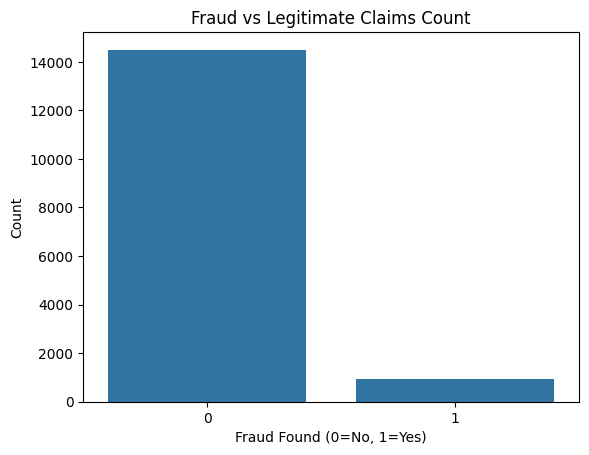

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(x='FraudFound_P', data=df)
plt.title('Fraud vs Legitimate Claims Count')
plt.xlabel('Fraud Found (0=No, 1=Yes)')
plt.ylabel('Count')
plt.show()


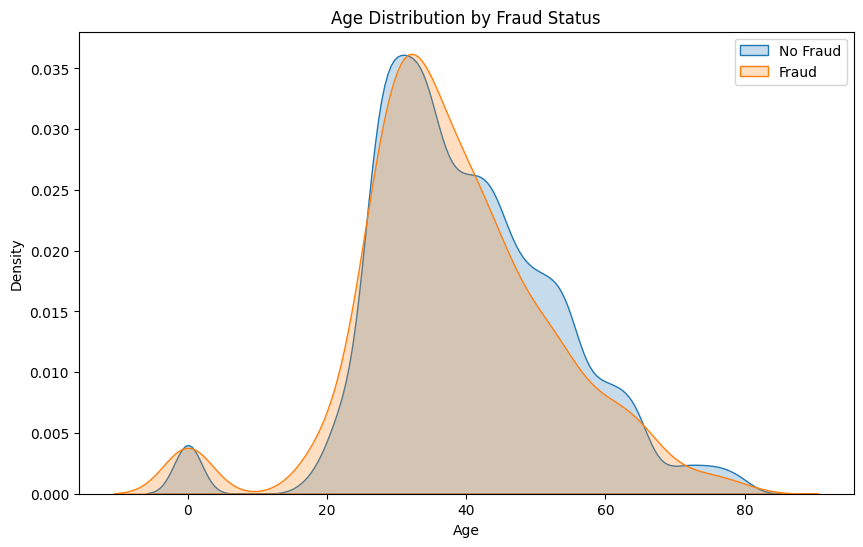

In [ ]:
plt.figure(figsize=(10,6))
sns.kdeplot(df.loc[df['FraudFound_P'] == 0, 'Age'], label='No Fraud', shade=True)
sns.kdeplot(df.loc[df['FraudFound_P'] == 1, 'Age'], label='Fraud', shade=True)
plt.title('Age Distribution by Fraud Status')
plt.xlabel('Age')
plt.legend()
plt.show()


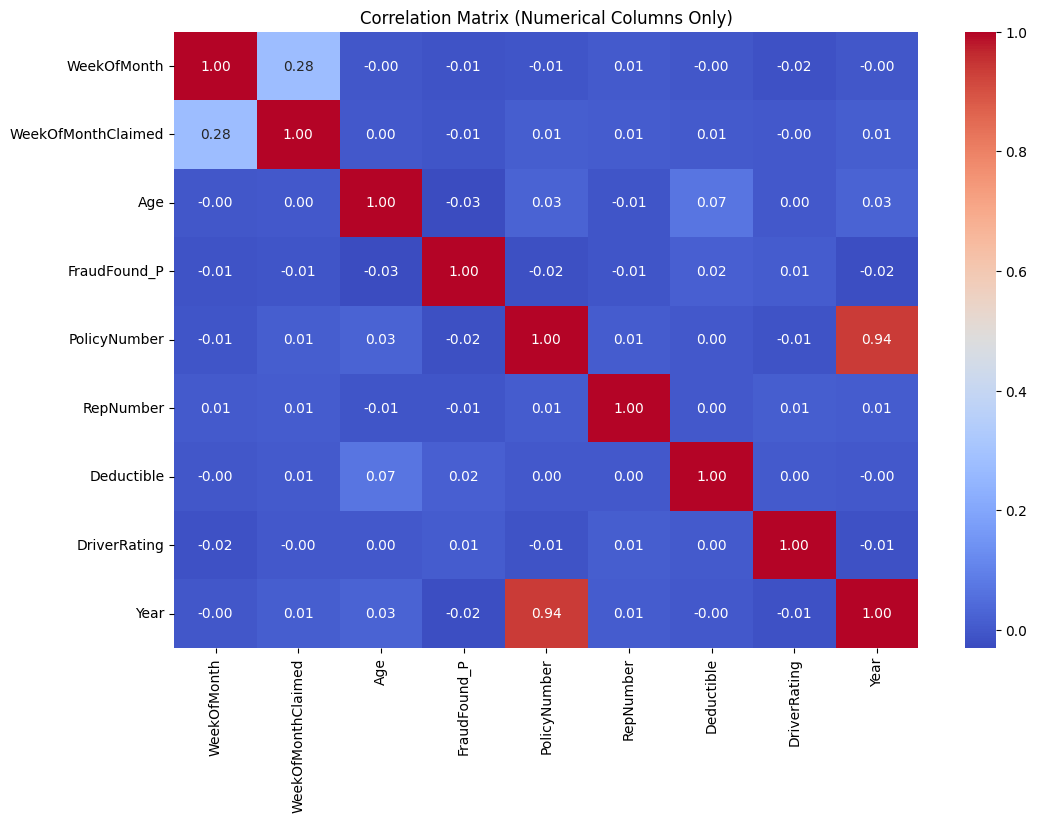

In [ ]:
plt.figure(figsize=(12,8))
# Select only numerical columns for correlation calculation
numerical_df = df.select_dtypes(include=np.number)
sns.heatmap(numerical_df.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix (Numerical Columns Only)')
plt.show()

In [ ]:
# prompt: implement using logistic regression

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Separate target variable
X = df.drop('FraudFound_P', axis=1)
y = df['FraudFound_P']

# Identify categorical and numerical features
categorical_features = X.select_dtypes(include=['object', 'category']).columns
numerical_features = X.select_dtypes(include=np.number).columns

# Create preprocessing pipelines for numerical and categorical features
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore') # handle_unknown='ignore' for unseen categories

# Create a column transformer to apply different transformations to different columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)])

# Create the logistic regression model pipeline
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', LogisticRegression(solver='liblinear'))]) # Using 'liblinear' solver for smaller datasets

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y) # stratify to maintain proportion of target variable

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.940337224383917

Classification Report:
               precision    recall  f1-score   support

           0       0.94      1.00      0.97      2899
           1       0.67      0.01      0.02       185

    accuracy                           0.94      3084
   macro avg       0.80      0.51      0.50      3084
weighted avg       0.92      0.94      0.91      3084


Confusion Matrix:
 [[2898    1]
 [ 183    2]]


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

X = df.drop('FraudFound_P', axis=1)
y = df['FraudFound_P']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd # Ensure pandas is imported if it wasn't in the previous cell

# Load dataset (assuming 'df' is already loaded and basic cleaning is done)
# If 'df' needs to be reloaded or is not available, uncomment and run this block:
# path = kagglehub.dataset_download("shivamb/vehicle-claim-fraud-detection") # Assuming path is still valid
# df = pd.read_csv(path + '/fraud_oracle.csv')
# df.replace("?", pd.NA, inplace=True)
# df.drop_duplicates(inplace=True)


# Separate features (X) and target (y)
X = df.drop('FraudFound_P', axis=1)
y = df['FraudFound_P']

# Identify categorical columns (object type)
categorical_cols = X.select_dtypes(include='object').columns

# Apply one-hot encoding to categorical columns
# handle_unknown='ignore' is useful if your test set might have categories not seen in the training set
X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True, dummy_na=False)

# Split the encoded data
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Now proceed with model training
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      2887
           1       1.00      0.01      0.01       197

    accuracy                           0.94      3084
   macro avg       0.97      0.50      0.49      3084
weighted avg       0.94      0.94      0.91      3084



In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd # Ensure pandas is imported

# Features and label
X = df.drop('FraudFound_P', axis=1)
y = df['FraudFound_P']

# Identify categorical columns (object type)
categorical_cols = X.select_dtypes(include='object').columns

# Apply one-hot encoding to categorical columns
# This converts string columns like 'Month', 'VehicleCategory', etc. into numerical columns
X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True, dummy_na=False)


# Scale features using the encoded data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded) # Use X_encoded instead of X

# Train-test split using the scaled data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Now you can proceed with training your KNN model
# For example:
# knn_model = KNeighborsClassifier(n_neighbors=5)
# knn_model.fit(X_train, y_train)
# y_pred = knn_model.predict(X_test)
# print(classification_report(y_test, y_pred))

In [ ]:
# KNN classifier with k=5 (you can tune it)
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

# Predict and evaluate
y_pred_knn = knn.predict(X_test)
print(confusion_matrix(y_test, y_pred_knn))
print(classification_report(y_test, y_pred_knn))


[[2872   15]
 [ 192    5]]
              precision    recall  f1-score   support

           0       0.94      0.99      0.97      2887
           1       0.25      0.03      0.05       197

    accuracy                           0.93      3084
   macro avg       0.59      0.51      0.51      3084
weighted avg       0.89      0.93      0.91      3084



In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_scaled, y)


In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Assume df is your dataframe, with FraudFound_P as label
X = df.drop('FraudFound_P', axis=1)
y = df['FraudFound_P']

# Convert categorical columns to numeric via one-hot encoding
X = pd.get_dummies(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [ ]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)


In [ ]:
# Calculate imbalance ratio
scale_pos_weight = (y == 0).sum() / (y == 1).sum()

params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'scale_pos_weight': scale_pos_weight,
    'eta': 0.1,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42
}


In [ ]:
evals = [(dtrain, 'train'), (dtest, 'eval')]

bst = xgb.train(params, dtrain, num_boost_round=1000, early_stopping_rounds=20, evals=evals, verbose_eval=10)


[0]	train-auc:0.84237	eval-auc:0.82794
[10]	train-auc:0.88983	eval-auc:0.85079
[20]	train-auc:0.90764	eval-auc:0.85139
[30]	train-auc:0.92881	eval-auc:0.85929
[40]	train-auc:0.95670	eval-auc:0.88709
[50]	train-auc:0.97586	eval-auc:0.91024
[60]	train-auc:0.98215	eval-auc:0.91359
[70]	train-auc:0.98584	eval-auc:0.91329
[80]	train-auc:0.99118	eval-auc:0.92071
[90]	train-auc:0.99463	eval-auc:0.93539
[100]	train-auc:0.99620	eval-auc:0.94060
[110]	train-auc:0.99717	eval-auc:0.94212
[120]	train-auc:0.99818	eval-auc:0.94959
[130]	train-auc:0.99860	eval-auc:0.95332
[140]	train-auc:0.99894	eval-auc:0.95829
[150]	train-auc:0.99923	eval-auc:0.96321
[160]	train-auc:0.99944	eval-auc:0.96370
[170]	train-auc:0.99956	eval-auc:0.96412
[180]	train-auc:0.99967	eval-auc:0.96543
[190]	train-auc:0.99977	eval-auc:0.96599
[200]	train-auc:0.99982	eval-auc:0.96556
[208]	train-auc:0.99987	eval-auc:0.96589


In [ ]:
y_pred_proba = bst.predict(dtest)
y_pred = (y_pred_proba > 0.5).astype(int)

print(classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_proba))


              precision    recall  f1-score   support

           0       0.98      0.97      0.98      2899
           1       0.62      0.76      0.68       185

    accuracy                           0.96      3084
   macro avg       0.80      0.87      0.83      3084
weighted avg       0.96      0.96      0.96      3084

ROC AUC Score: 0.966113198400194


In [ ]:
import numpy as np
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
f1_scores = 2 * (precision * recall) / (precision + recall)

best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

print(f"Best threshold for F1 score: {best_threshold}")

# Use best threshold for final prediction
y_pred_final = (y_pred_proba > best_threshold).astype(int)
print(classification_report(y_test, y_pred_final))


Best threshold for F1 score: 0.610464334487915
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      2899
           1       0.73      0.69      0.71       185

    accuracy                           0.97      3084
   macro avg       0.86      0.84      0.85      3084
weighted avg       0.97      0.97      0.97      3084



In [ ]:
import joblib
import json

# Save the trained model
joblib.dump(bst, 'xgboost_fraud_model.pkl')

# Save the threshold
with open('best_threshold.json', 'w') as f:
    json.dump({'threshold': float(best_threshold)}, f)

For k=2, silhouette score: 0.0281
For k=3, silhouette score: 0.0332
For k=4, silhouette score: 0.0406
For k=5, silhouette score: 0.0404
For k=6, silhouette score: 0.0437
For k=7, silhouette score: 0.0340
For k=8, silhouette score: 0.0358
For k=9, silhouette score: 0.0470
For k=10, silhouette score: 0.0485


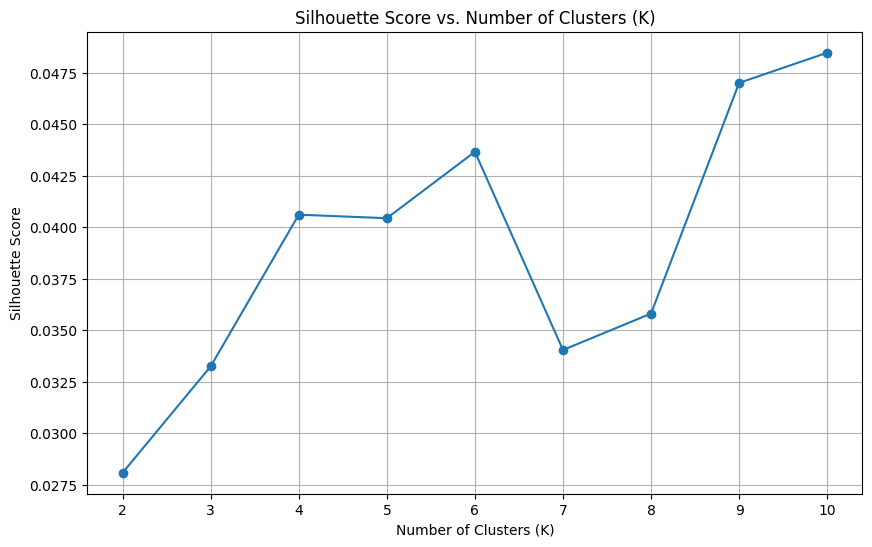


Fraud Rate per Cluster:
FraudFound_P         0         1
Cluster                         
0             0.942939  0.057061
1             0.915742  0.084258
2             0.887468  0.112532
3             0.992878  0.007122


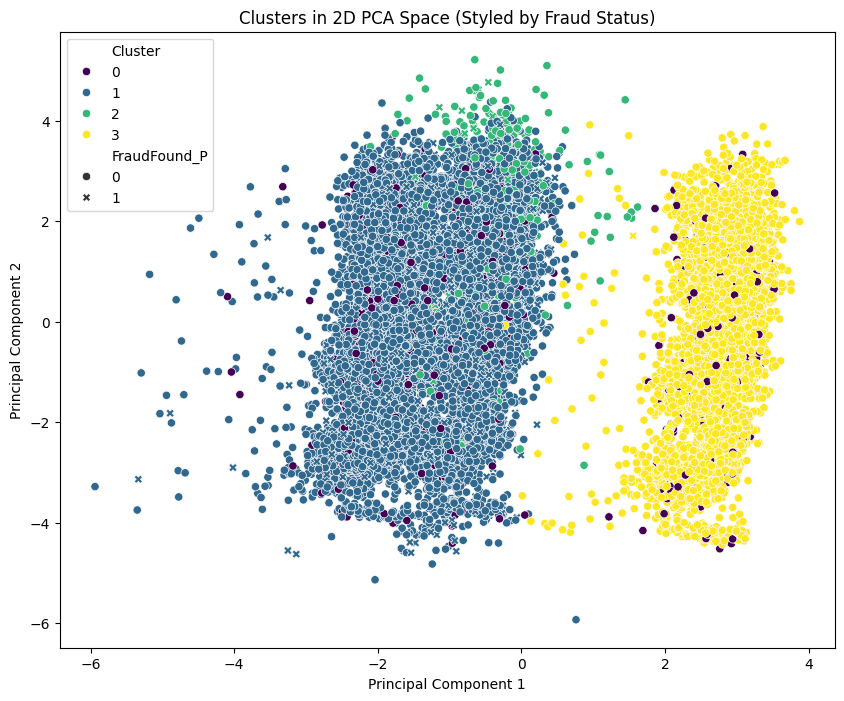

In [ ]:
# prompt: Implementation using clustering

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Assuming X_scaled is available from the previous StandardScaler step

# Choose a range of k values to test
k_range = range(2, 11) # Testing k from 2 to 10

# Store silhouette scores
silhouette_scores = []

# Apply KMeans for each k
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10) # Added n_init
    kmeans.fit(X_scaled)
    score = silhouette_score(X_scaled, kmeans.labels_)
    silhouette_scores.append(score)
    print(f"For k={k}, silhouette score: {score:.4f}")


# Plot silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(k_range, silhouette_scores, marker='o')
plt.title('Silhouette Score vs. Number of Clusters (K)')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.xticks(k_range)
plt.grid(True)
plt.show()

# Choose the best k based on the silhouette score (or domain knowledge)
# Let's choose k=4 based on the plot (you might choose differently based on results)
best_k = 4

# Apply KMeans with the best k
kmeans_final = KMeans(n_clusters=best_k, random_state=42, n_init=10) # Added n_init
kmeans_final.fit(X_scaled)

# Add cluster labels to the original (or processed) dataframe
# Note: Adding to the original 'df' might require mapping back or ensuring alignment
# For simplicity, let's add to a new dataframe created from X_scaled
df_clustered = pd.DataFrame(X_scaled, columns=X_encoded.columns) # Using X_encoded columns for clarity
df_clustered['Cluster'] = kmeans_final.labels_
df_clustered['FraudFound_P'] = y.reset_index(drop=True) # Add the target variable back

# Analyze clusters (e.g., fraud rate per cluster)
cluster_fraud_rate = df_clustered.groupby('Cluster')['FraudFound_P'].value_counts(normalize=True).unstack().fillna(0)
print("\nFraud Rate per Cluster:")
print(cluster_fraud_rate)

# Visualize clusters (using first two principal components for 2D visualization)
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

df_pca_clustered = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
df_pca_clustered['Cluster'] = kmeans_final.labels_
df_pca_clustered['FraudFound_P'] = y.reset_index(drop=True)


plt.figure(figsize=(10, 8))
sns.scatterplot(data=df_pca_clustered, x='PC1', y='PC2', hue='Cluster', style='FraudFound_P', palette='viridis', legend='full')
plt.title('Clusters in 2D PCA Space (Styled by Fraud Status)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# You can further analyze cluster centroids or other features per cluster
# print("\nCluster Centroids:")
# print(kmeans_final.cluster_centers_)
